In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, \
    f1_score, ConfusionMatrixDisplay
import seaborn as sns
import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load and Preprocess the Dataset
Here, we load the dataset from the CSV files and preprocess it for training the model.


In [4]:
# Load the preprocessed data from CSV files
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

In [5]:
X_train = train_data['text']
y_train = train_data['label']

X_val = val_data['text']
y_val = val_data['label']

X_test = test_data['text']
y_test = test_data['label']

## Step 3: Load Pre-trained Word2Vec Embeddings
We use pre-trained Word2Vec embeddings to represent words as dense vectors.
These embeddings improve the performance of the model by leveraging semantic relationships between words.

In [6]:
# Load pre-trained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [7]:
# Create a vocabulary
embedding_dim = 300
vocab = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
embedding_matrix = [np.zeros(embedding_dim),
                    np.random.uniform(-0.01, 0.01, embedding_dim)]  # Initialize <PAD> and <UNK>

In [8]:
# Build vocabulary from Word2Vec
for text in X_train:
    for word in word_tokenize(text.lower()):
        if word not in vocab and word in word2vec:
            vocab[word] = len(vocab)
            embedding_matrix.append(word2vec[word])

embedding_matrix = np.array(embedding_matrix)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 71330


In [9]:
print(embedding_matrix.shape)


(71330, 300)
[ 0.03466797  0.10839844 -0.03735352  0.0390625  -0.15527344  0.09619141
 -0.03015137  0.01226807 -0.04980469  0.04101562 -0.19140625 -0.10058594
 -0.13183594  0.01879883 -0.14257812  0.10742188 -0.08154297  0.09472656
 -0.09716797 -0.07470703 -0.0546875  -0.05322266  0.04614258 -0.06689453
  0.00204468  0.03686523 -0.04663086 -0.11669922 -0.0008812   0.006073
 -0.00448608  0.04980469  0.03271484 -0.03930664 -0.09716797  0.04052734
  0.11230469  0.0456543   0.12988281  0.08105469  0.06542969 -0.08984375
  0.17285156 -0.04101562  0.00396729  0.00842285 -0.04321289  0.05859375
 -0.13964844  0.06884766 -0.20117188  0.14941406 -0.00982666  0.02893066
  0.19921875  0.00662231 -0.13183594 -0.04785156  0.07958984 -0.05981445
  0.01672363  0.1796875   0.10986328  0.03173828 -0.04443359 -0.14160156
 -0.01434326  0.13183594 -0.12060547 -0.03808594  0.01013184  0.01153564
 -0.08007812 -0.01818848 -0.22558594 -0.12158203 -0.03173828  0.06030273
  0.07568359 -0.03149414 -0.11035156  0.

## Step 4: Tokenize and Pad Sequences
Convert the text into sequences of integers based on the vocabulary.
We also pad sequences to ensure they all have the same length for batch processing.

In [10]:
# Tokenize and convert text to sequences
def text_to_sequence(text, vocab, max_len=1000):
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in word_tokenize(text.lower())]
    if len(sequence) < max_len:
        sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
    return sequence[:max_len]


# Apply tokenization
max_len = 750
X_train_seq = [text_to_sequence(text, vocab, max_len) for text in X_train]
X_val_seq = [text_to_sequence(text, vocab, max_len) for text in X_val]
X_test_seq = [text_to_sequence(text, vocab, max_len) for text in X_test]

In [11]:
# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [12]:
# Create Dataset and DataLoader
batch_size = 32
train_dataset = TextDataset(X_train_seq, y_train)
val_dataset = TextDataset(X_val_seq, y_val)
test_dataset = TextDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
## Step 6: Define the MLP Model

In [14]:
class MLPModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dims=[128, 64], output_dim=1):
        super(MLPModel, self).__init__()

        # Embedding Layer with frozen weights
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,
            padding_idx=0
        )

        # Calculate input dimension
        input_dim = embedding_matrix.shape[1] * max_len

        # Create list to hold all layers
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.LayerNorm(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(0.6))

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.LayerNorm(hidden_dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))  # Increased dropout

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Get embeddings and flatten
        embedded = self.embedding(x)
        flattened = embedded.view(embedded.size(0), -1)

        # Forward pass through all layers
        return self.model(flattened)

## Step 7: Initialize the Model 
We initialize the model with the embedding matrix.

In [15]:
model = MLPModel(embedding_matrix).to(device)

## Step 8: Function for Train the Model
We train the model using the training and validation datasets and monitor the loss and accuracy.
To calculate the loss, we use the Binary Cross-Entropy loss function.
We use the Adam optimizer to update the model parameters based on the gradients.
To prevent overfitting, we make use of early stopping and learning rate scheduling.


In [16]:
def calculate_metrics(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    # Calculate TP, FP, FN
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    false_negatives = np.sum((predictions == 0) & (labels == 1))

    # Calculate precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Calculate recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate F1
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


In [17]:
def train_model(model, train_loader, val_loader, epochs=15, learning_rate=1e-4):
    num_pos = sum(y_train == 1)
    num_neg = sum(y_train == 0)
    pos_weight = torch.tensor([num_neg / num_pos]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.1
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        verbose=True
    )

    best_model_state = None
    best_val_loss = float('inf')
    patience = 4
    patience_counter = 0

    metrics_history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': []
    }

    num_warmup_steps = 100

    def get_lr(step):
        if step < num_warmup_steps:
            return learning_rate * (step / num_warmup_steps)
        return learning_rate

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for i, (texts, labels) in enumerate(train_loader):
            current_lr = get_lr(epoch * len(train_loader) + i)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

            texts = texts.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(texts).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            predicted = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predicted.detach())
            all_labels.extend(labels.detach())
            total_loss += loss.item()

            if i % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item():.4f}')

        # Calculate training metrics
        train_predictions = torch.stack(all_predictions)
        train_labels = torch.stack(all_labels)
        train_acc = (train_predictions == train_labels).float().mean().item()
        train_precision, train_recall, train_f1 = calculate_metrics(train_predictions, train_labels)

        # Validation phase
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for texts, labels in val_loader:
                texts = texts.to(device)
                labels = labels.float().to(device)

                outputs = model(texts).squeeze(-1)
                loss = criterion(outputs, labels)
                predicted = torch.round(torch.sigmoid(outputs))

                val_loss += loss.item()
                val_predictions.extend(predicted.detach())
                val_labels.extend(labels.detach())

        # Calculate validation metrics
        val_predictions = torch.stack(val_predictions)
        val_labels = torch.stack(val_labels)
        val_acc = (val_predictions == val_labels).float().mean().item()
        val_precision, val_recall, val_f1 = calculate_metrics(val_predictions, val_labels)

        # Update metrics history
        metrics_history['train_loss'].append(total_loss / len(train_loader))
        metrics_history['val_loss'].append(val_loss / len(val_loader))
        metrics_history['train_acc'].append(train_acc)
        metrics_history['val_acc'].append(val_acc)
        metrics_history['train_precision'].append(train_precision)
        metrics_history['val_precision'].append(val_precision)
        metrics_history['train_recall'].append(train_recall)
        metrics_history['val_recall'].append(val_recall)
        metrics_history['train_f1'].append(train_f1)
        metrics_history['val_f1'].append(val_f1)

        # Print metrics
        print(f'Epoch: {epoch}')
        print(f'Train Loss: {metrics_history["train_loss"][-1]:.4f}')
        print(f'Val Loss: {metrics_history["val_loss"][-1]:.4f}')
        print(f'Train Acc: {train_acc:.4f}')
        print(f'Val Acc: {val_acc:.4f}')
        print(f'Train Precision: {train_precision:.4f}')
        print(f'Val Precision: {val_precision:.4f}')
        print(f'Train Recall: {train_recall:.4f}')
        print(f'Val Recall: {val_recall:.4f}')
        print(f'Train F1: {train_f1:.4f}')
        print(f'Val F1: {val_f1:.4f}')

        scheduler.step(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(best_model_state, 'best_mlp_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered')
            model.load_state_dict(best_model_state)
            break

    return metrics_history

## Step 9: Plot Training History
We plot the training history to visualize the loss, accuracy, precision, recall, and F1 score over epochs.


In [18]:
def plot_training_history(metrics_history):
    # Set up the style
    # plt.style.use('seaborn')

    # Create a figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot losses
    ax1.plot(metrics_history['train_loss'], label='Training Loss')
    ax1.plot(metrics_history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(metrics_history['train_acc'], label='Training Accuracy')
    ax2.plot(metrics_history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Plot precision and recall
    ax3.plot(metrics_history['train_precision'], label='Training Precision')
    ax3.plot(metrics_history['val_precision'], label='Validation Precision')
    ax3.plot(metrics_history['train_recall'], label='Training Recall')
    ax3.plot(metrics_history['val_recall'], label='Validation Recall')
    ax3.set_title('Precision and Recall Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.legend()

    # Plot F1 scores
    ax4.plot(metrics_history['train_f1'], label='Training F1')
    ax4.plot(metrics_history['val_f1'], label='Validation F1')
    ax4.set_title('F1 Score Over Time')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1 Score')
    ax4.legend()

    plt.tight_layout()
    plt.show()

## Step 10: Plot the Confusion Matrix
We plot the confusion matrix to visualize the model's performance on the test set.

In [19]:
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            outputs = model(texts).squeeze(-1)
            predicted = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))

## Step 11: Train the Model
We train the model using the training and validation datasets and monitor the loss and accuracy.
This process may take a while, depending on the number of epochs and the complexity of the model.

In [20]:
metrics_history = train_model(model, train_loader, val_loader, epochs=15)

c:\Users\dell\OneDrive - Ariel University\Desktop\a\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 0.6183
Epoch: 0, Batch: 100, Loss: 0.5678
Epoch: 0, Batch: 200, Loss: 0.4905
Epoch: 0, Batch: 300, Loss: 0.5169
Epoch: 0, Batch: 400, Loss: 0.5033
Epoch: 0, Batch: 500, Loss: 0.5837
Epoch: 0, Batch: 600, Loss: 0.4787
Epoch: 0, Batch: 700, Loss: 0.3492
Epoch: 0, Batch: 800, Loss: 0.2113
Epoch: 0, Batch: 900, Loss: 0.2102
Epoch: 0, Batch: 1000, Loss: 0.2498
Epoch: 0, Batch: 1100, Loss: 0.4135
Epoch: 0, Batch: 1200, Loss: 0.3490
Epoch: 0, Batch: 1300, Loss: 0.3282
Epoch: 0
Train Loss: 0.4020
Val Loss: 0.3077
Train Acc: 0.8045
Val Acc: 0.8735
Train Precision: 0.8350
Val Precision: 0.9044
Train Recall: 0.8005
Val Recall: 0.8594
Train F1: 0.8174
Val F1: 0.8813
Epoch: 1, Batch: 0, Loss: 0.1701
Epoch: 1, Batch: 100, Loss: 0.2466
Epoch: 1, Batch: 200, Loss: 0.1800
Epoch: 1, Batch: 300, Loss: 0.1004
Epoch: 1, Batch: 400, Loss: 0.2184
Epoch: 1, Batch: 500, Loss: 0.1888
Epoch: 1, Batch: 600, Loss: 0.1776
Epoch: 1, Batch: 700, Loss: 0.2926
Epoch: 1, Batch: 800, Loss: 0.198

## Save the model

In [21]:
torch.save(model.state_dict(), "MLP_model.pth")

## Step 12: Evaluate the Model
plot the training history and evaluate the model on the test set.

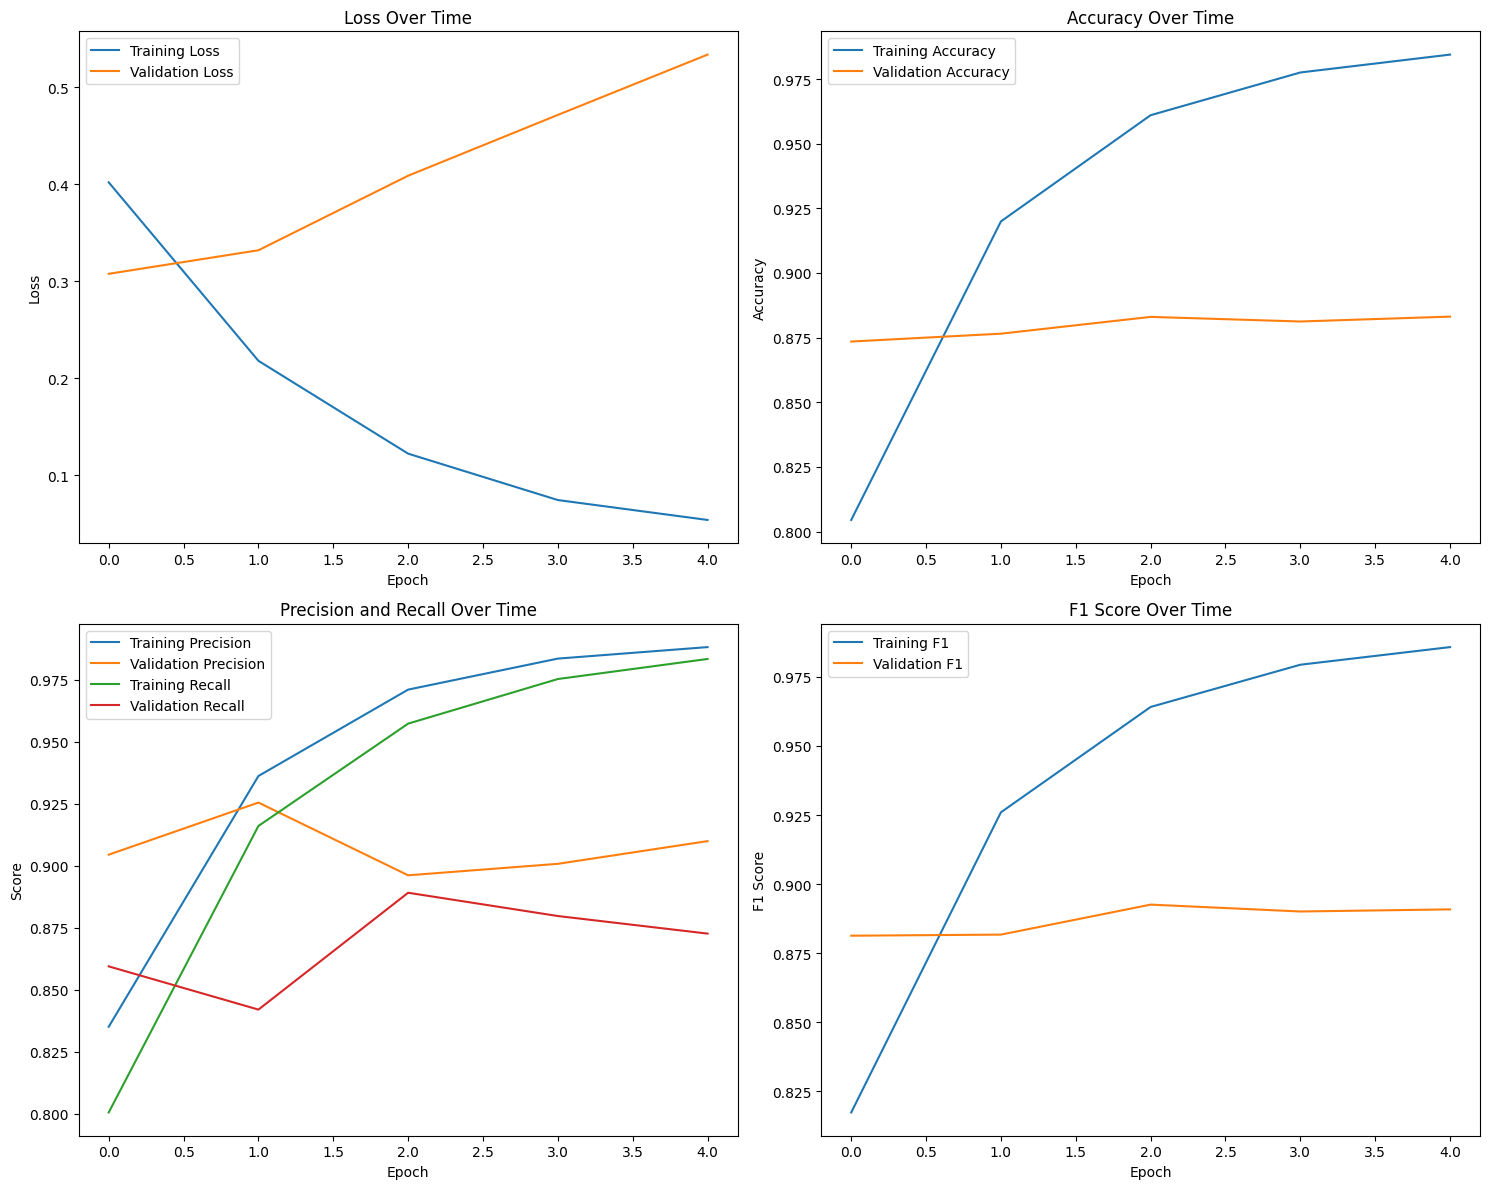

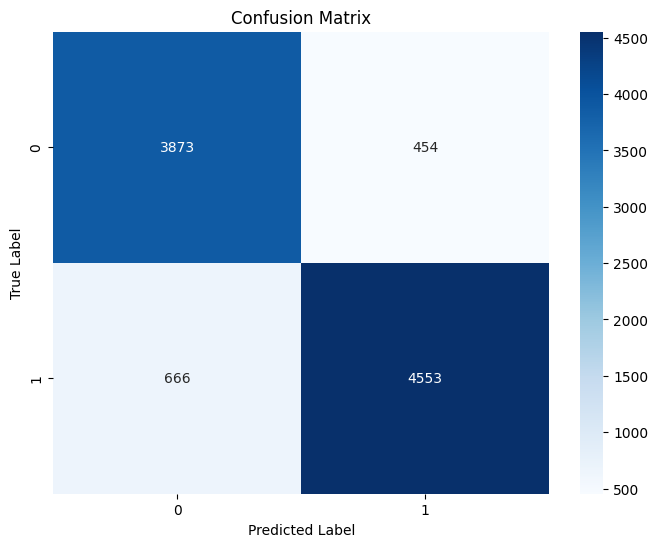


Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      4327
         1.0       0.91      0.87      0.89      5219

    accuracy                           0.88      9546
   macro avg       0.88      0.88      0.88      9546
weighted avg       0.88      0.88      0.88      9546


In [22]:
plot_training_history(metrics_history)
plot_confusion_matrix(model, test_loader)

### plot the loss over epochs

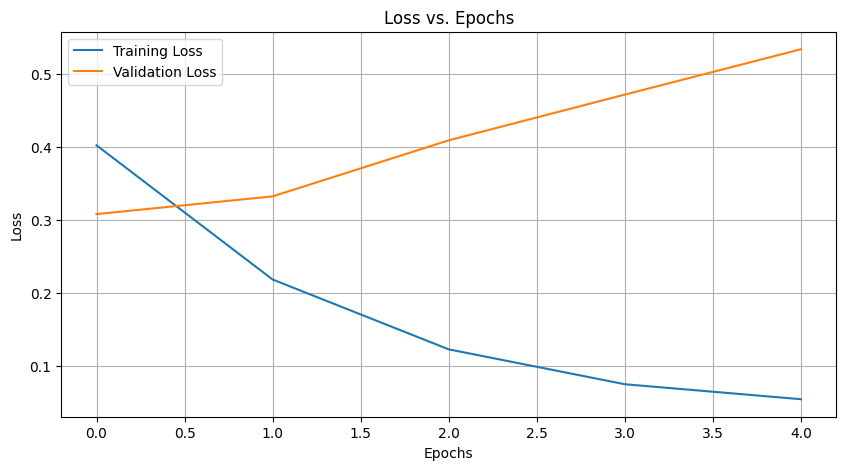

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_loss'], label='Training Loss')
plt.plot(metrics_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("loss_vs_epochs_first try.png")  # Save the current plot


### plot the Accuracy over epochs

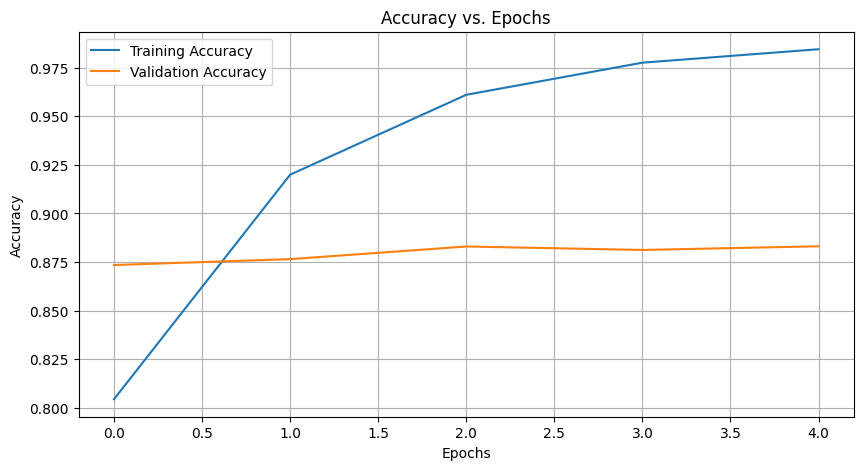

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_acc'], label='Training Accuracy')
plt.plot(metrics_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("accuracy_vs_epochs_first_try.png")  # Save the current plot

### plot the precision, recall and f1-score over epochs

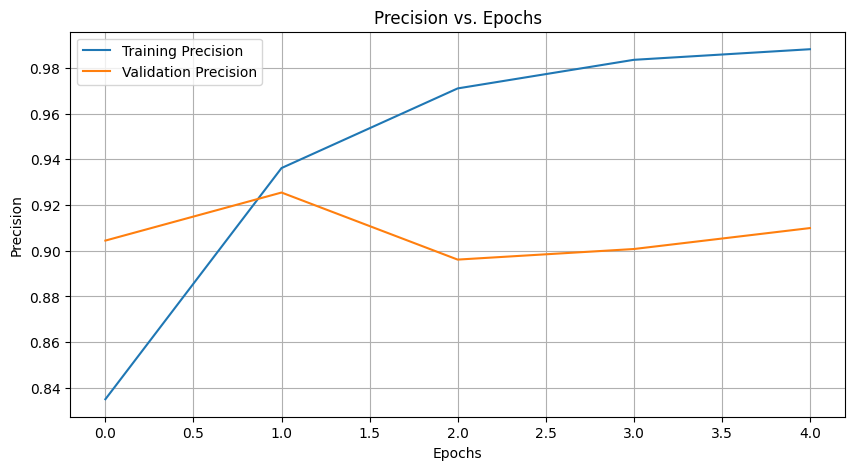

<Figure size 640x480 with 0 Axes>

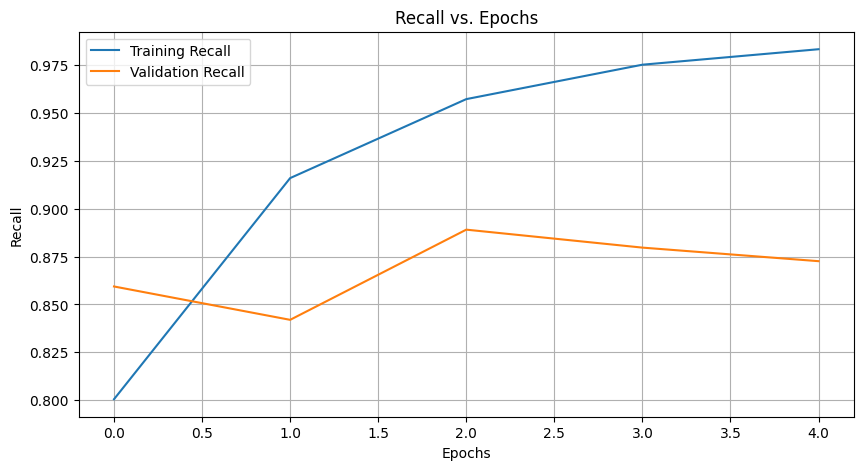

<Figure size 640x480 with 0 Axes>

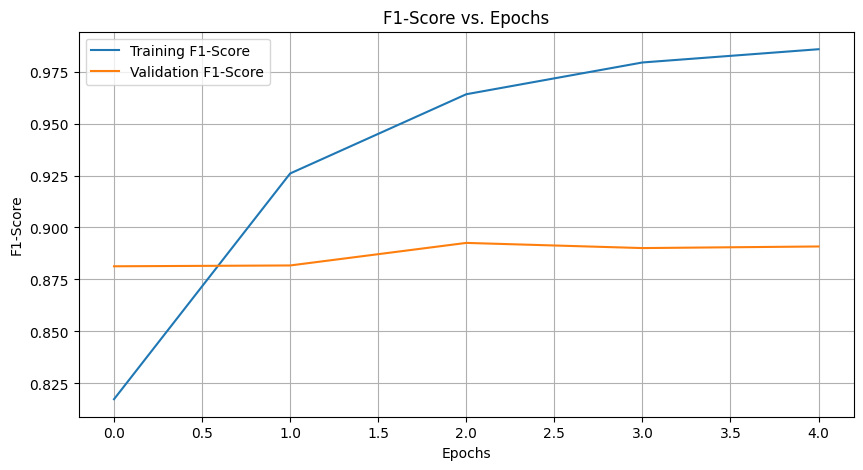

<Figure size 640x480 with 0 Axes>

In [25]:
# Precision
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_precision'], label='Training Precision')
plt.plot(metrics_history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("precision_vs_epochs_first_try.png")  # Save the current

# Recall
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_recall'], label='Training Recall')
plt.plot(metrics_history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("recall_vs_epochs_first_try.png")  # Save the current plot

# F1-Score
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_f1'], label='Training F1-Score')
plt.plot(metrics_history['val_f1'], label='Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("f1_score_vs_epochs_first_try.png")  # Save the current plot


## Step 14: Print out the final evaluation metrics

In [26]:
# Test the model
model.eval()
with torch.no_grad():
    test_predictions, test_labels = [], []
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze()
        predictions = torch.round(torch.sigmoid(predictions))
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8827
Test Precision: 0.9093
Test Recall: 0.8724
Test F1 Score: 0.8905


## Save the model
### this step saves the training history to a JSON file and the model to a .pth file.

In [27]:
import json

# Save metrics history to a JSON file
with open("metrics_history.json", "w+") as f:
    json.dump(metrics_history, f)

### Save the final state of the model

In [28]:
torch.save(model.state_dict(), "fcnn_model.pth")

### save the embeddings

In [29]:
np.save("embedding_matrix.npy", embedding_matrix)

## Test the model with the test

In [30]:
def evaluate_model_on_test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.float().to(device)

            outputs = model(texts).squeeze(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = {
        'accuracy': accuracy_score(all_labels, all_predictions),
        'precision': precision_score(all_labels, all_predictions, average='macro'),
        'recall': recall_score(all_labels, all_predictions, average='macro'),
        'f1': f1_score(all_labels, all_predictions, average='macro')
    }

    return total_loss / len(test_loader), metrics, all_labels, all_predictions

Test Loss: 0.5755
Test Accuracy: 0.8827
Test Precision: 0.8813
Test Recall: 0.8837
Test F1 Score: 0.8821


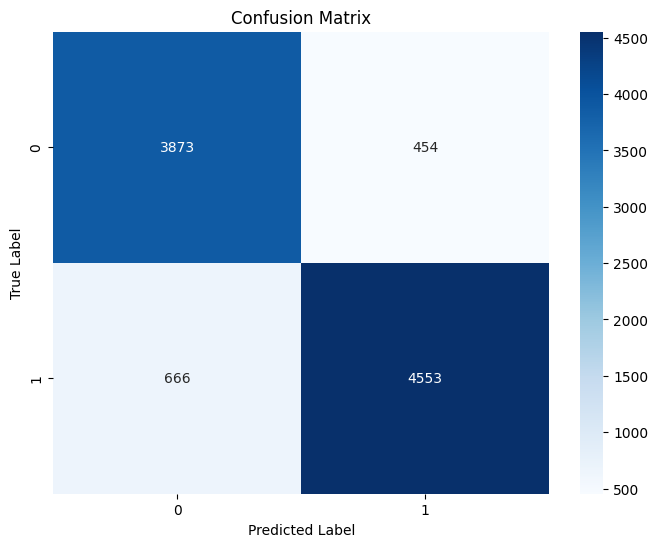


Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      4327
         1.0       0.91      0.87      0.89      5219

    accuracy                           0.88      9546
   macro avg       0.88      0.88      0.88      9546
weighted avg       0.88      0.88      0.88      9546


In [31]:
# Assuming you have already defined the criterion (loss function)
criterion = nn.BCEWithLogitsLoss()

test_loss, test_metrics, test_labels, test_predictions = evaluate_model_on_test(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))



##